In [1]:

pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install ipython


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
import scipy.io
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape,LeakyReLU)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam ,SGD
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers import L2, L1
from tensorflow.keras.initializers import RandomNormal
from IPython.display import Image, display
import PIL
from PIL import ImageOps
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras.models import Model,Sequential
import scipy.io

### DATA PREPARATION

In [31]:
IN_X,IN_Y=768,1024
OUT_X,OUT_Y=96,128
SUBSAMPLING_FACTOR=IN_X//OUT_X

In [42]:
def gauss_distribution(x,u=0,sigma=2):
    return np.expand_dims(1/(np.sqrt(2*np.pi*(sigma**2)))*np.exp(-(0.5)*(((x-u)/sigma)**2)),axis=0)

In [43]:
def get_density_map_gaussian(im,points,gaussian_radius=4):
    density_map=np.zeros((OUT_X,OUT_Y))
    w,h=OUT_Y,OUT_X
    num_gt=len(points)
    
    for point in points:
        point=np.round(point).astype(int)
        point[0],point[1]=min(h-1,point[1]),min(w-1,point[0])
        
        x=np.linspace(-gaussian_radius,gaussian_radius,(gaussian_radius*2)+1)
        
        gaussian_map=np.multiply(gauss_distribution(x),gauss_distribution(x).T)
        gaussian_map/=np.sum(gaussian_map)
        
        x_left,x_right,y_up,y_down=0,gaussian_map.shape[1],0,gaussian_map.shape[0]
        
        if point[1]<gaussian_radius:
            x_left=gaussian_radius-point[1]
            
        if point[0]<gaussian_radius:
            y_up=gaussian_radius-point[0]
            
        if point[1]+gaussian_radius>=w:
            x_right=gaussian_map.shape[1]-(gaussian_radius+point[1]-w)-1
            
        if point[0]+gaussian_radius>=h:
            y_down=gaussian_map.shape[0]-(gaussian_radius+point[0]-h)-1
            
        density_map[
            max(0,point[0]-gaussian_radius):min(density_map.shape[0],point[0]+gaussian_radius+1),
            max(0,point[1]-gaussian_radius):min(density_map.shape[1],point[1]+gaussian_radius+1),
        ]+=gaussian_map[y_up:y_down,x_left:x_right]
        
    density_map/=np.sum(density_map/len(points))
    
    return density_map

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


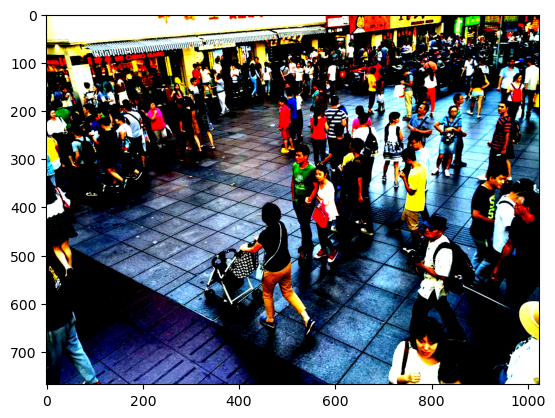

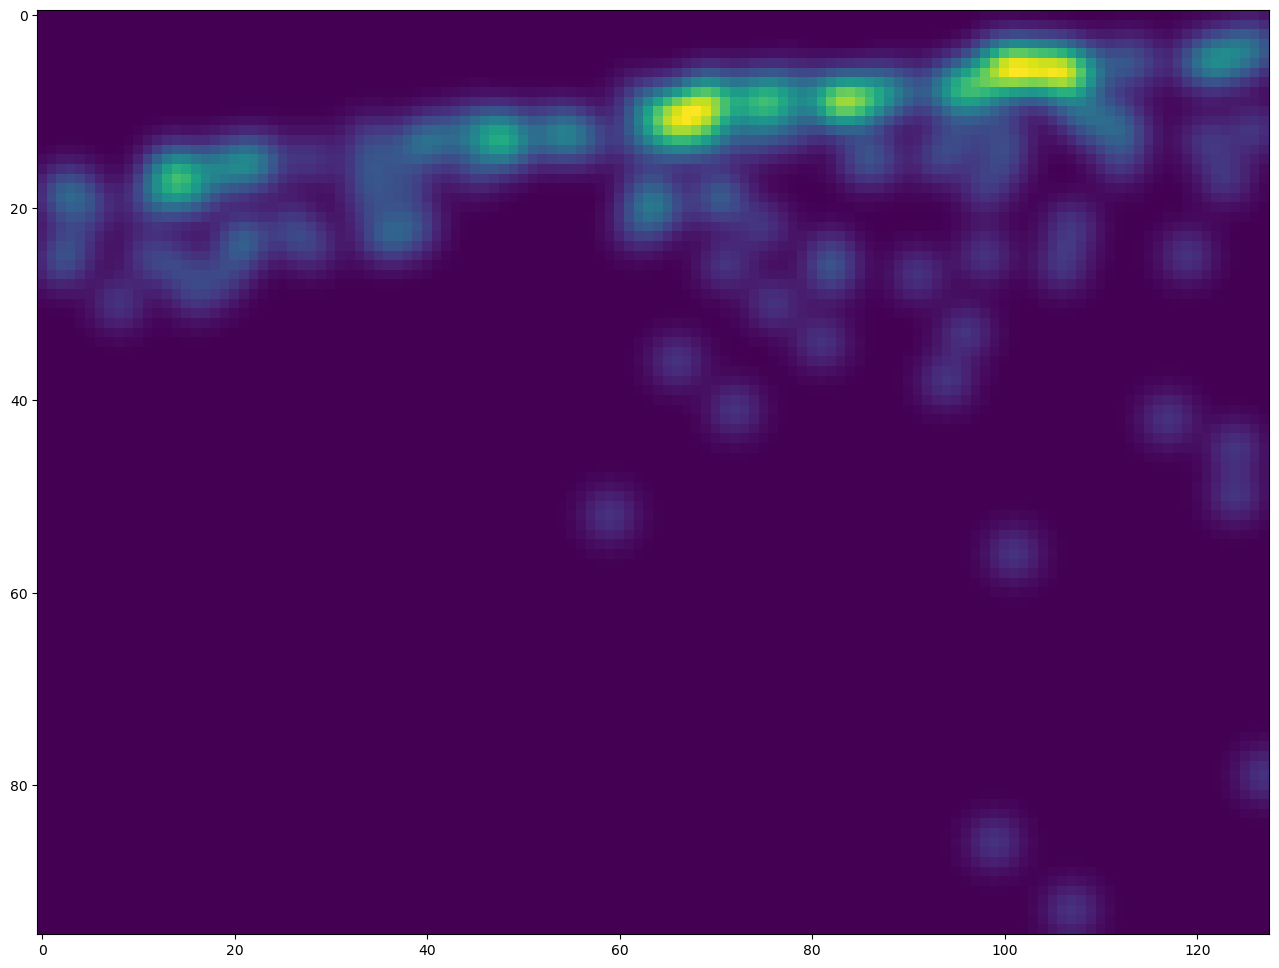

In [47]:
train_images="C:/Users/ADMIN/archive (7)/ShanghaiTech/part_B/train_data/images/"
train_maps="C:/Users/ADMIN/archive (7)/ShanghaiTech/part_B/train_data/ground-truth/"

IN='IMG_44'
im_array=img_to_array(load_img(train_images + IN + '.jpg', target_size= (IN_X, IN_Y)))

im_array/=255
im_array[:,:,0]=(im_array[:,:,0]-np.mean(im_array[:,:,0]))/np.std(im_array[:,:,0])
im_array[:,:,1]=(im_array[:,:,1]-np.mean(im_array[:,:,1]))/np.std(im_array[:,:,1])
im_array[:,:,2]=(im_array[:,:,2]-np.mean(im_array[:,:,2]))/np.std(im_array[:,:,2])

X=im_array
plt.imshow(X)

mat=scipy.io.loadmat(train_maps + 'GT_'+IN + '.mat')

points=mat['image_info'][0][0][0][0][0]

points /= SUBSAMPLING_FACTOR
y=get_density_map_gaussian(im_array,points,gaussian_radius=5,)
                          



plt.figure(figsize=(20,12))
plt.imshow(y)

plt.show()

In [52]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__ (self, images, maps, batch_size,SUBSAMPLING_FACTOR=8):

        self.images = images
        self.maps = maps
        self.batch_size = batch_size
        self.train_image_list=os.listdir(images)
        self.SUBSAMPLING_FACTOR=SUBSAMPLING_FACTOR

    def __len__(self):
        return int(np.floor(len(self.train_image_list)/self.batch_size))
  
    def __getitem__(self, idx):
        x,y = self.__data_generation(idx)
        return x,y
  
    def __data_generation(self, idx):
        x = []
        y = []

        for j in range(idx*self.batch_size, (idx+1)*self.batch_size):
            
            im_array=img_to_array(load_img(self.images+os.listdir(self.images)[j],target_size=(IN_X,IN_Y)))
            im_array/=255.
            im_array[:,:,0]=(im_array[:,:,0]-np.mean(im_array[:,:,0]))/np.std(im_array[:,:,0])
            im_array[:,:,1]=(im_array[:,:,1]-np.mean(im_array[:,:,1]))/np.std(im_array[:,:,1])
            im_array[:,:,2]=(im_array[:,:,2]-np.mean(im_array[:,:,2]))/np.std(im_array[:,:,2])
            
            x.append(im_array)
            
            mat=scipy.io.loadmat(self.maps+os.listdir(self.maps)[j])
            points=mat['image_info'][0][0][0][0][0]
            points/=self.SUBSAMPLING_FACTOR
            
            density_map_present=get_density_map_gaussian(im_array,points,sigma=5)
            y.append(density_map_present)
        return tf.convert_to_tensor(x),tf.convert_to_tensor(y)

In [91]:
train_images="C:/Users/ADMIN/archive (7)/ShanghaiTech/part_B/train_data/images/"
train_maps="C:/Users/ADMIN/archive (7)/ShanghaiTech/part_B/train_data/ground-truth/"
#val_image="C:/Users/ADMIN/archive (7)/ShanghaiTech/part_B/test_data/images/"
#val_maps="C:/Users/ADMIN/archive (7)/ShanghaiTech/part_B/test_data/ground-truth/"

LR=1e-4
BATCH_SIZE=1
EPOCH=1000

In [94]:
import os
train_gen = DataGenerator(train_images, train_maps, BATCH_SIZE, IN_X)
#val_gen = DataGenerator(val_images, val_maps,BATCH_SIZE,INPUT_DIM)

## MODELLING


In [95]:
from tensorflow.keras.applications import VGG16

In [115]:
from keras.models import Model
from keras.applications import VGG16

def get_base_model():
    base_model = VGG16(
        weights='imagenet',
        input_shape=(IN_X, IN_Y, 3),
        include_top=False,
    )
    block4_conv3 = [base_model.get_layer(layer_name).output for layer_name in ["block4_conv3"]]
    return Model(
        inputs=base_model.inputs,  # Remove the outer list
        outputs=block4_conv3
    )

model = get_base_model().summary()
model


Model: "functional_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_43 (InputLayer)          │ (None, 768, 1024, 3)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 768, 1024, 64)       │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 768, 1024, 64)       │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 384, 512, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 384, 512, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 384, 512, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 192, 256, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 192, 256, 256)       │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 192, 256, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 192, 256, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 96, 128, 256)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 96, 128, 512)        │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 96, 128, 512)        │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 96, 128, 512)        │       2,359,808 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,635,264 (29.13 MB)

 Trainable params: 7,635,264 (29.13 MB)

 Non-trainable params: 0 (0.00 B)

### TRAINING

In [102]:
def custom_loss(y_true,y_pred):
    return tf.sqrt(tf.math.reduce_sum(tf.square(y_true-y_pred)))

In [127]:
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print("Error: Unable to load image at path:", img_path)
        return None
    img = cv2.resize(img, (224, 224))
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)
    return img
img_path = image_path


In [130]:
model.summary()

Model: "functional_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_49 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [133]:
LR= 1e-5
model.compile(
    loss = custom_loss,
    optimizer = Adam(learning_rate=LR,),
    metrics=['accuracy','mae'],
    run_eagerly = True,
)
#checkpoint_filepath="C:/Users/ADMIN/archive (7)/ShanghaiTech/part_B/test_data/images/"

In [ ]:
model.fit(train_gen, epochs=1000, verbose=1, shuffle=True)

### TESTING

In [80]:
IN ="C:/Users/ADMIN/archive (7)/ShanghaiTech/part_B/test_data/images/"

im_array=img_to_array(load_img(train_image+IN_'.jpg',target_size=(IN_X,IN_Y)))
im_array/=255.
im_array[:,:,0]=(im_array[:,:,0]-np.mean(im_array[:,:,0]))/np.std(im_array[:,:,0])
im_array[:,:,1]=(im_array[:,:,1]-np.mean(im_array[:,:,1]))/np.std(im_array[:,:,1])
im_array[:,:,2]=(im_array[:,:,2]-np.mean(im_array[:,:,2]))/np.std(im_array[:,:,2])

plt.figure(figsize=(20,12))
plt.imhow(im_array)

output=mode.predict(tf.expand_dims(im_array,axis=0))
output=np.reshape(output,(OUT_X,OUT_Y))

n_people=np.sum(output)
mat=scipy.io.loadmat(train_maps+'GT_'+IN+'.mat')
points=mat['image_info'][0][0][0][0][0]
points/=SUBSAMPLING_FACTOR

num_gt=np.squeeze(points).shape[0]
print("The actual number of people is=",num_gt)
print("The predicted number of people is =",n_people)

plt.figure(figsize=(20,12))
plt.imshow(output)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (468008223.py, line 3)